PDE 损失: 5.63e-05 | 边界损失: 1.66e-05 | 总损失: 4.47e-05: 100%|██████████| 100/100 [04:50<00:00,  2.91s/it]


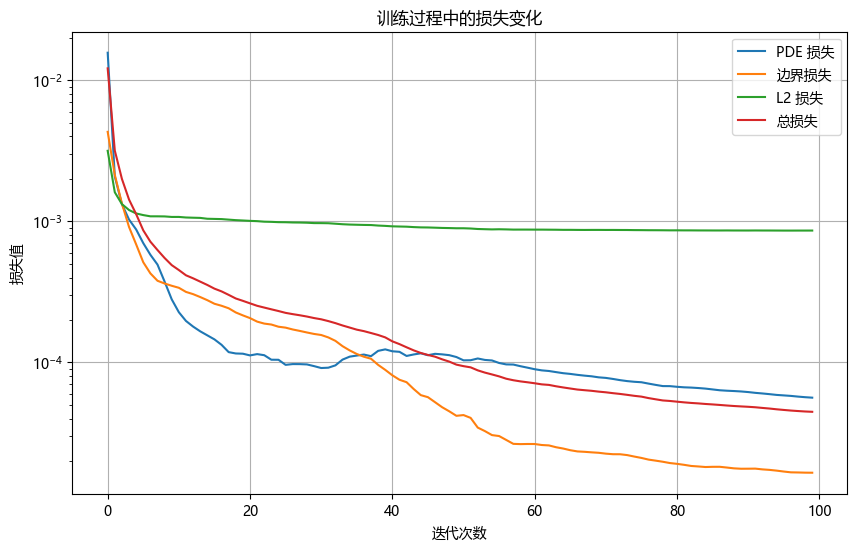

In [7]:
from kan import *
import torch
from torch import nn, optim, autograd
from torch import autograd
from tqdm import tqdm
import matplotlib.pyplot as plt


# 定义维度和参数
dim = 2
np_i = 21  # 内部点数（每个维度）
ranges = [-1, 1]

# 初始化 KAN 模型
model = KAN(width=[2, 10, 1], grid=5, k=3, grid_eps=1.0, noise_scale_base=0.25)

def batch_jacobian(func, x, create_graph=False):
    # 计算批次雅可比矩阵的函数
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1, 0, 2)

# 定义解析解和源项（二维泊松方程）
sol_fun = lambda x: 0.25 * (x[:, [0]]**2 - 1) * (x[:, [1]]**2 - 1)
source_fun = lambda x: -2 * (x[:, [0]]**2 + x[:, [1]]**2)

# 内部点采样模式 ('mesh' 或 'random')
sampling_mode = 'mesh'

x_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
y_mesh = torch.linspace(ranges[0], ranges[1], steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")

if sampling_mode == 'mesh':
    # 使用网格点作为内部点
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0)
else:
    # 在域内随机采样内部点
    x_i = torch.rand((np_i**2, 2)) * 2 - 1

# 边界点（域的四条边）
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:, 0], Y[:, 0])
xb4 = helper(X[:, 0], Y[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

# 训练参数
steps = 100  # 优化步数
alpha = 0.5  # PDE 损失相对于边界损失的权重
log = 1  # 日志记录频率

# 用于存储训练过程中损失的列表
pde_losses = []
bc_losses = []
l2_losses = []
losses = []

def train():
    # 初始化 LBFGS 优化器
    optimizer = LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    # optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 进度条用于可视化训练进度
    pbar = tqdm(range(steps), desc='训练进度')

    for _ in pbar:
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()

            # 计算内部点的 PDE 损失
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:, :, :]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            # pde_loss = torch.mean((lap - source) ** 2)
            delta = 1.0
            pde_loss = torch.mean(torch.where(torch.abs(lap - source) < delta, 0.5 * (lap - source)**2, delta * (torch.abs(lap - source) - 0.5 * delta)))

            # 计算边界损失
            bc_true = sol_fun(x_b)
            # bc_true = torch.cat([
            #    torch.sin(torch.pi * xb1[:, 1]).unsqueeze(1),
            #    torch.sin(torch.pi * xb2[:, 1]).unsqueeze(1),
            #    torch.sin(torch.pi * xb3[:, 0]).unsqueeze(1),
            #    torch.sin(torch.pi * xb4[:, 0]).unsqueeze(1)
            # ], dim=0)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred - bc_true) ** 2)

            # 总损失
            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        # 执行优化步骤
        optimizer.step(closure)

        # 计算内部点的 L2 损失
        sol = sol_fun(x_i)
        l2 = torch.mean((model(x_i) - sol) ** 2)

        # 将损失值存入列表
        pde_losses.append(pde_loss.item())
        bc_losses.append(bc_loss.item())
        l2_losses.append(l2.item())
        losses.append((alpha * pde_loss + bc_loss).item())

        # 更新进度条显示当前损失
        if _ % log == 0:
            pbar.set_description(f"PDE 损失: {pde_loss.item():.2e} | 边界损失: {bc_loss.item():.2e} | 总损失: {(alpha * pde_loss + bc_loss).item():.2e}")

    # 返回训练后的模型和损失数据
    return model, pde_losses, bc_losses, l2_losses, losses


# 开始训练模型并获取结果
trained_model, pde_losses, bc_losses, l2_losses, losses = train()

# 可视化预测解和解析解
with torch.no_grad():
    pred_solution = trained_model(x_i).reshape(np_i, np_i).cpu().numpy()
    exact_solution = sol_fun(x_i).reshape(np_i, np_i).cpu().numpy()

plt.rcParams['font.family'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(pde_losses, label='PDE 损失')
plt.plot(bc_losses, label='边界损失')
plt.plot(l2_losses, label='L2 损失')
plt.plot(losses, label='总损失')
plt.yscale('log')
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.legend()
plt.title('训练过程中的损失变化')
plt.grid(True)
plt.show()

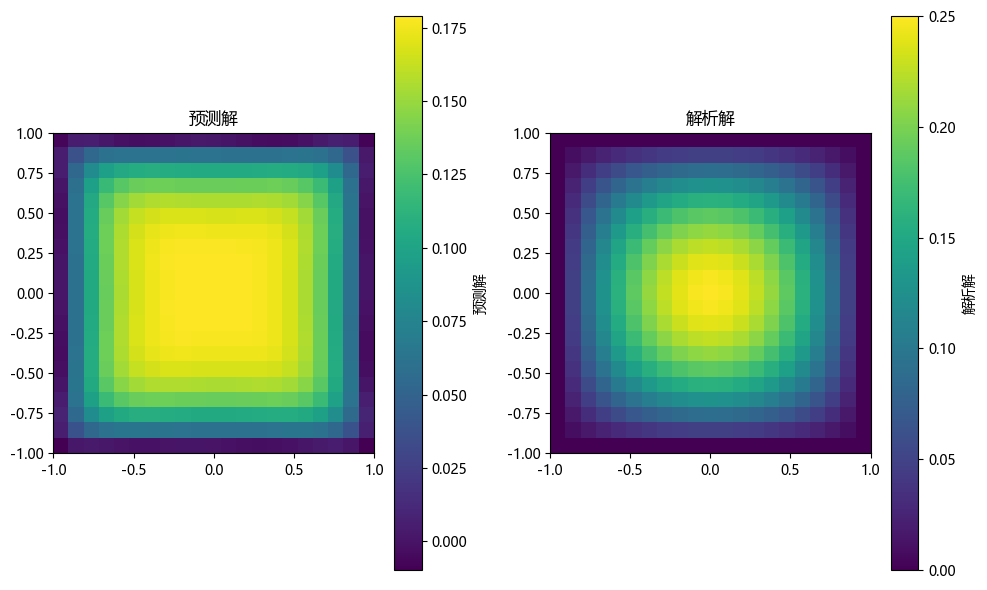

In [8]:
# 绘制预测解和解析解
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(pred_solution, extent=[ranges[0], ranges[1], ranges[0], ranges[1]], origin='lower')
plt.colorbar(label='预测解')
plt.title('预测解')

plt.subplot(1, 2, 2)
plt.imshow(exact_solution, extent=[ranges[0], ranges[1], ranges[0], ranges[1]], origin='lower')
plt.colorbar(label='解析解')
plt.title('解析解')

plt.tight_layout()
plt.show()

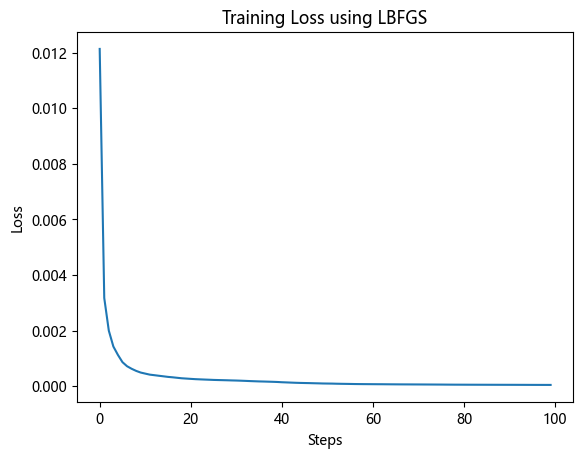

In [9]:
# 绘制损失
plt.plot(losses)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss using LBFGS')
plt.show()

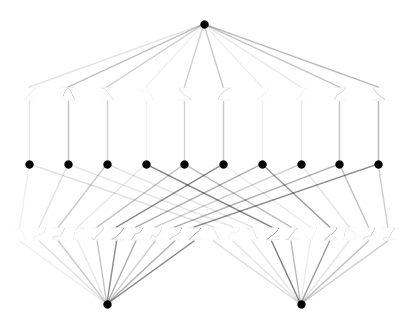

In [10]:
model.plot()

In [11]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with tanh, r2=0.9850262403488159
fixing (0,0,1) with x^3, r2=0.9988331198692322
fixing (0,0,2) with x^3, r2=0.9890213012695312
fixing (0,0,3) with tanh, r2=0.9983531832695007
fixing (0,0,4) with abs, r2=0.9891627430915833
fixing (0,0,5) with x^3, r2=0.9998193979263306
fixing (0,0,6) with sqrt, r2=0.9576695561408997
fixing (0,0,7) with x^3, r2=0.979165256023407
fixing (0,0,8) with sqrt, r2=0.9899622797966003
fixing (0,0,9) with sqrt, r2=0.9959625005722046
fixing (0,1,0) with tanh, r2=0.996820867061615
fixing (0,1,1) with x^3, r2=0.9843856692314148
fixing (0,1,2) with tanh, r2=0.9919031858444214
fixing (0,1,3) with sqrt, r2=0.9982041716575623
fixing (0,1,4) with sin, r2=0.9962209463119507
fixing (0,1,5) with x^2, r2=0.9611113667488098
fixing (0,1,6) with sqrt, r2=0.9935832619667053
fixing (0,1,7) with x^4, r2=0.8732328414916992
fixing (0,1,8) with x^3, r2=0.9834280014038086
fixing (0,1,9) with tanh, r2=0.9833046197891235
fixing (1,0,0) with sin, r2=0.9999995231628418
fixin

In [12]:
train()

PDE 损失: nan | 边界损失: nan | 总损失: nan:  70%|███████   | 70/100 [04:27<01:54,  3.82s/it]


KeyboardInterrupt: 

In [ ]:
formula, var = model.symbolic_formula(floating_digit=5)
formula[0]